we start with 3204769 transcripts, only 532080 transcripts that were assigned to our polygons
from xenium we know that they detected 216323 cells, we detected 147344 or 83947 after processing (including filtering of 4489, because polygon was not uniquely mapped to a cell)

In [1]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-08-30 13:44:57.258708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

id                                           geometry
0            ID_1  POLYGON ((2116.705 352.000, 2115.873 353.964, ...
1            ID_2  POLYGON ((2988.448 2654.000, 2988.674 2656.521...
2            ID_3  POLYGON ((2971.104 3174.000, 2970.065 3175.604...
3            ID_4  POLYGON ((3030.417 3494.000, 3029.509 3496.289...
4            ID_5  POLYGON ((3022.134 3302.000, 3021.518 3304.291...
...           ...                                                ...
216348  ID_216349  POLYGON ((27908.171 21580.000, 27907.469 21581...
216349  ID_216350  POLYGON ((28906.574 21238.000, 28907.262 21239...
216350  ID_216351  POLYGON ((27663.020 21014.000, 27662.251 21015...
216351  ID_216352  POLYGON ((28863.908 20810.000, 28864.447 20810...
216352  ID_216353  POLYGON ((28737.483 22054.000, 28737.127 22055...

[216353 rows x 2 columns]

In [3]:
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [4]:
adata_df = adata.to_df()

In [5]:
df_tissue_positions = adata_df
df_tissue_positions['index']=df_tissue_positions.index

In [6]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [7]:
gdf.crs = None

In [8]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [9]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [10]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [11]:
barcodes_in_one_polygon.shape

(532080, 546)

In [12]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

0    (0, 1376)
1    (0, 1400)
2    (0, 1402)
3    (0, 1425)
4    (0, 1429)
Name: index, dtype: object


geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0           (0, 1376)
1           (0, 1400)
2           (0, 1402)
3           (0, 1425)
4           (0, 1429)
             ...     
532075    (2201, 120)
532076    (2201, 122)
532077    (2201, 123)
532078    (2201, 126)
532079    (2201, 128)
Name: index, Length: 532080, dtype: object

In [13]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [14]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [15]:
filtered_adata = adata[filtered_obs_mask,:]

In [16]:
filtered_adata

View of AnnData object with n_obs × n_vars = 531974 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [17]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 531974
Length of barcodes_in_one_polygon: 531974


In [18]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1425)', '(0, 1429)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1425)    (0, 1425)
(0, 1429)    (0, 1429)
Name: index, dtype: object


In [19]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [20]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [21]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [22]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [23]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 147344 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [24]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [25]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [26]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [27]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


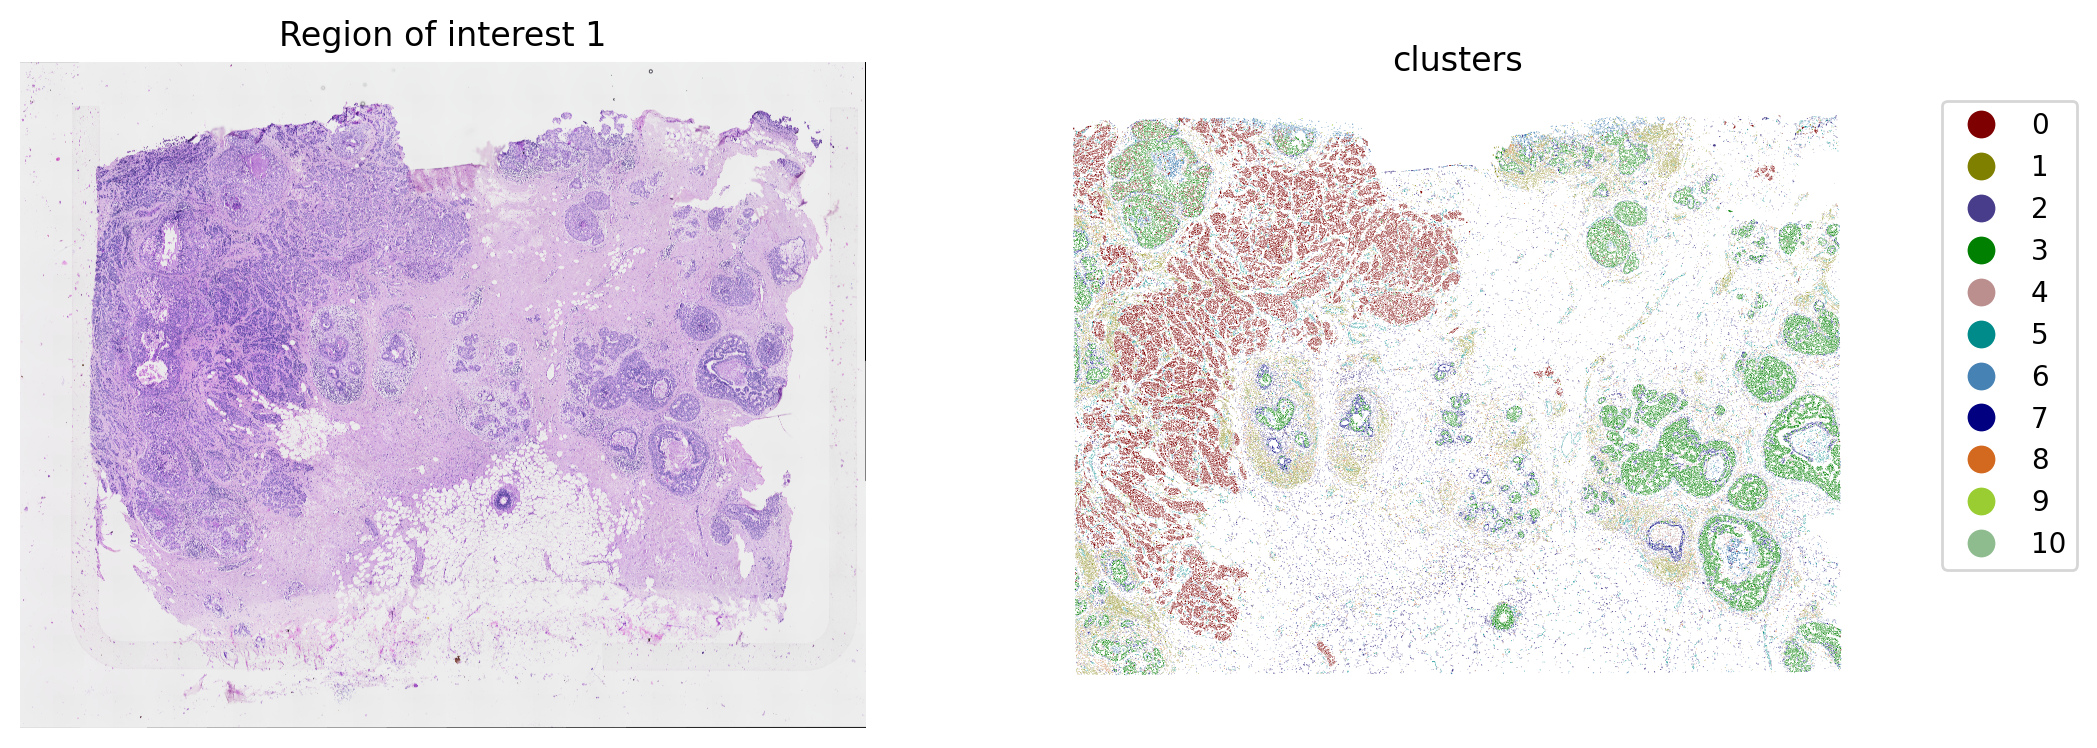

In [28]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [29]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

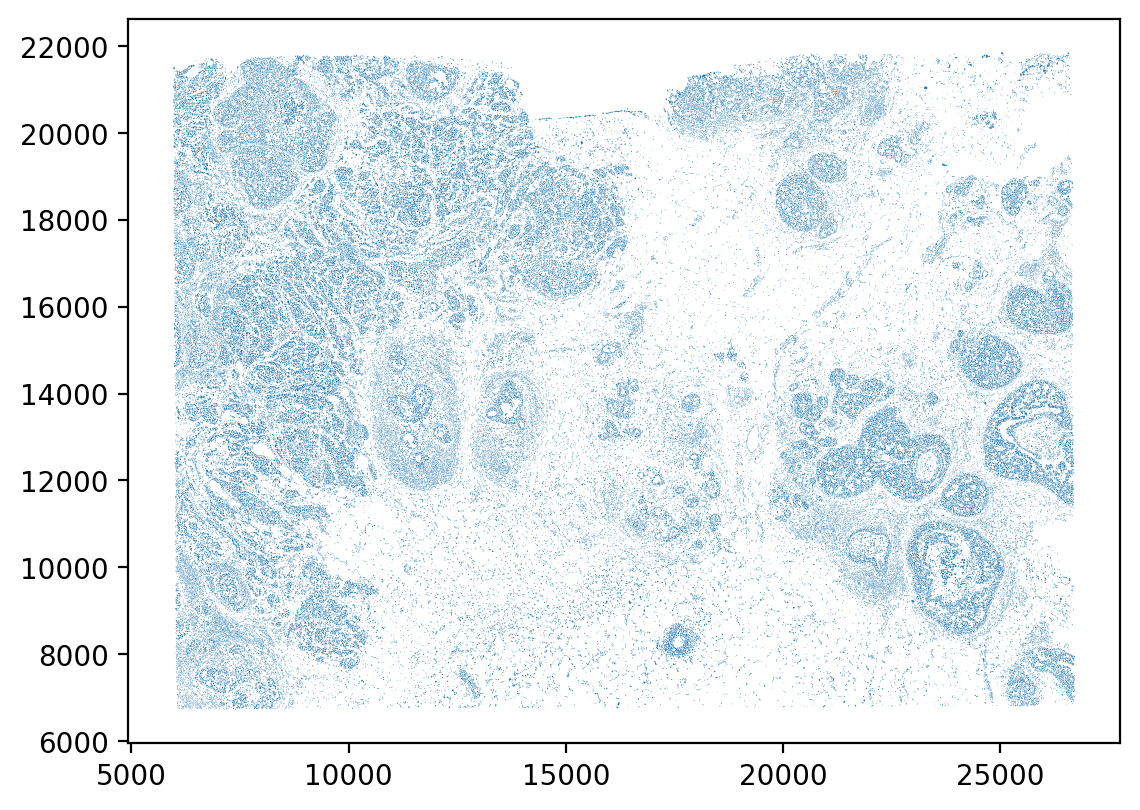

In [30]:
merged_gdf.plot()

In [31]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [32]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [33]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [34]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [35]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [36]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [37]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

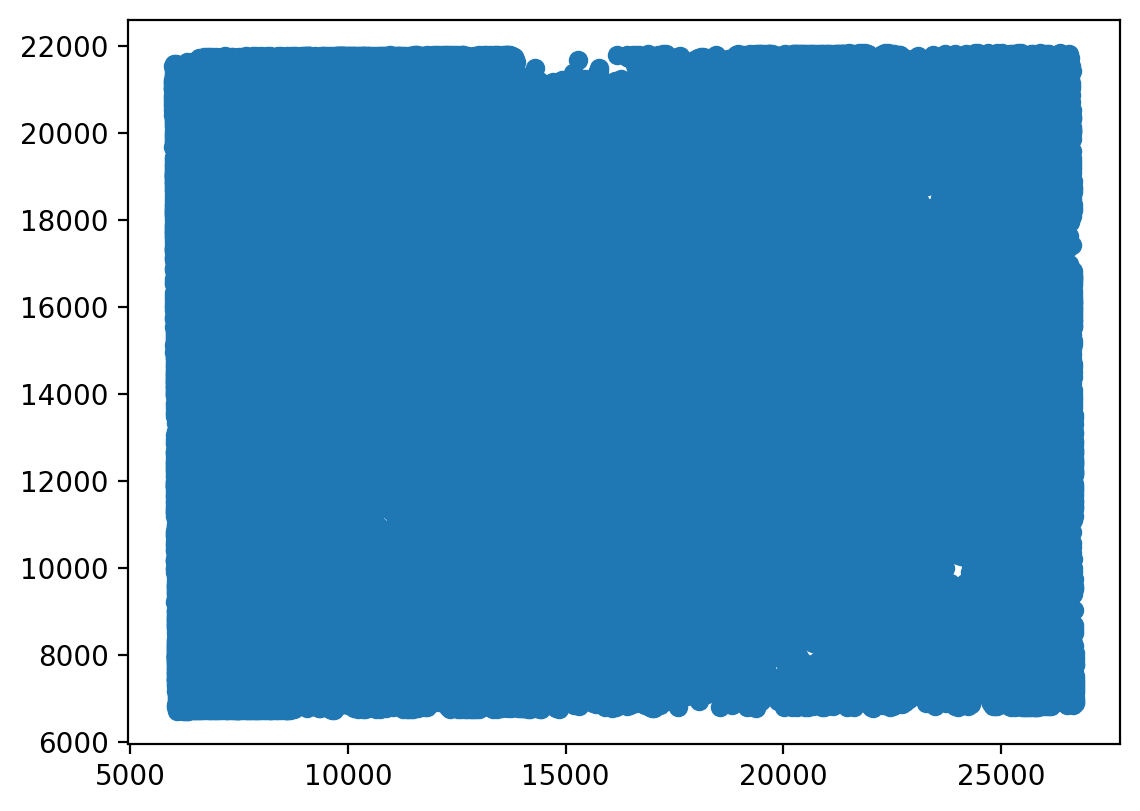

In [38]:
cells_gdf.plot()

In [39]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

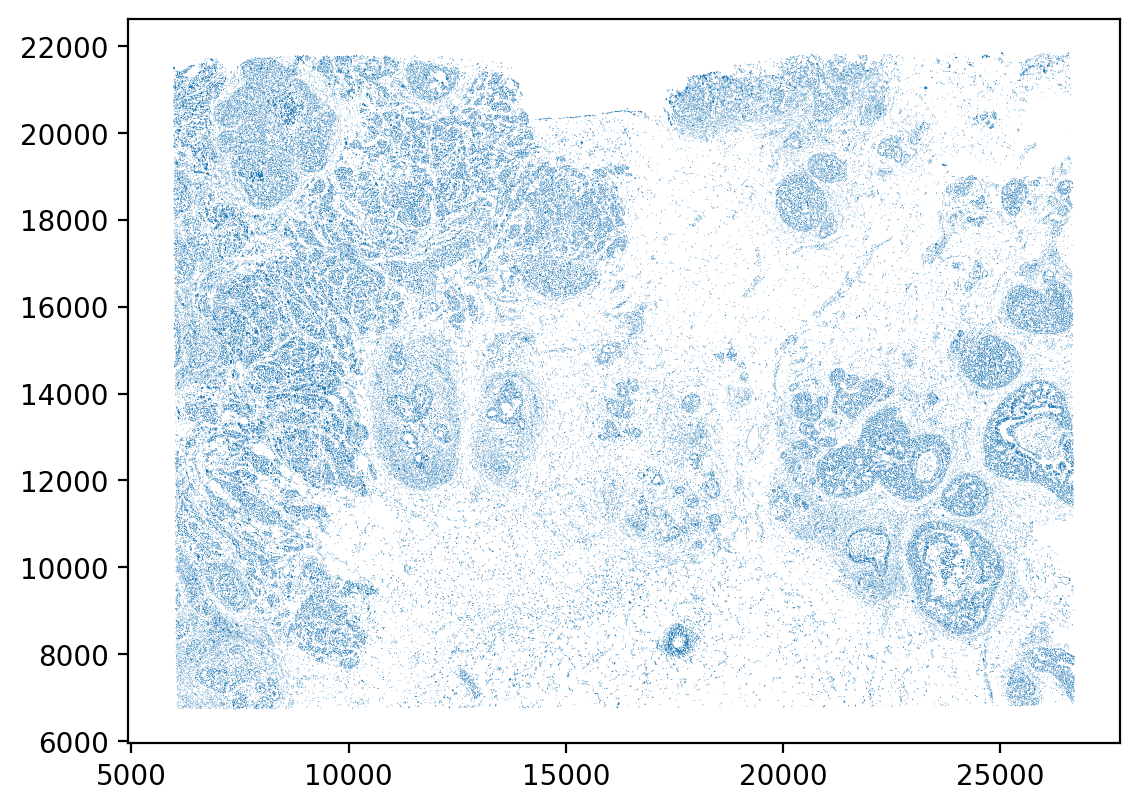

In [40]:
joined.plot()

In [41]:
joined

id                                           geometry   
6224      ID_6225  POLYGON ((7147.756 6836.000, 7147.470 6839.077...  \
6231      ID_6232  POLYGON ((6280.575 6964.000, 6280.311 6965.653...   
6234      ID_6235  POLYGON ((7205.946 6740.000, 7205.587 6741.907...   
6248      ID_6249  POLYGON ((6448.833 7252.000, 6448.276 7253.646...   
6252      ID_6253  POLYGON ((6924.299 7188.000, 6923.439 7190.275...   
...           ...                                                ...   
215214  ID_215215  POLYGON ((24364.991 21268.000, 24365.422 21269...   
215215  ID_215216  POLYGON ((25931.394 21776.000, 25931.607 21776...   
215217  ID_215218  POLYGON ((26654.858 21128.000, 26654.669 21128...   
215218  ID_215219  POLYGON ((25631.472 21608.000, 25631.918 21608...   
215220  ID_215221  POLYGON ((24879.726 21156.000, 24880.376 21156...   

        index_right  cell_id  x_centroid   y_centroid  transcript_counts   
6224        42284.0  42285.0  399.355255  5437.458716              592.0  \
6231        42966.0  42967.0   82.964026  5382.626245              173.0   
6234            NaN      NaN         NaN          NaN                NaN   
6248        43061.0  43062.0  145.100730  5281.886304              108.0   
6252        42582.0  42583.0  318.665202  5303.403174              252.0   
...             ...      ...         ...          ...                ...   
215214          NaN      NaN         NaN          NaN                NaN   
215215          NaN      NaN         NaN          NaN                NaN   
215217          NaN      NaN         NaN          NaN                NaN   
215218          NaN      NaN         NaN          NaN                NaN   
215220          NaN      NaN         NaN          NaN                NaN   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         592.0  \
6231                     0.0                      0.0         173.0   
6234                     NaN                      NaN           NaN   
6248                     0.0                      0.0         108.0   
6252                     1.0                      0.0         253.0   
...                      ...                      ...           ...   
215214                   NaN                      NaN           NaN   
215215                   NaN                      NaN           NaN   
215217                   NaN                      NaN           NaN   
215218                   NaN                      NaN           NaN   
215220                   NaN                      NaN           NaN   

         cell_area  nucleus_area  x_location_transformed   
6224    398.142656    147.525469             7135.520510  \
6231    179.405781     55.813125             6265.376854   
6234           NaN           NaN                     NaN   
6248    110.632812     36.079844             6434.772936   
6252    150.280000     75.320625             6911.997752   
...            ...           ...                     ...   
215214         NaN           NaN                     NaN   
215215         NaN           NaN                     NaN   
215217         NaN           NaN                     NaN   
215218         NaN           NaN                     NaN   
215220         NaN           NaN                     NaN   

        y_location_transformed  
6224               6822.211526  
6231               6968.648654  
6234                       NaN  
6248               7246.303336  
6252               7189.501397  
...                        ...  
215214                     NaN  
215215                     NaN  
215217                     NaN  
215218                     NaN  
215220                     NaN  

[152343 rows x 14 columns]

In [42]:
filtered_joined = joined[~joined['index_right'].isna()]

In [43]:
filtered_joined

id                                           geometry   
6224      ID_6225  POLYGON ((7147.756 6836.000, 7147.470 6839.077...  \
6231      ID_6232  POLYGON ((6280.575 6964.000, 6280.311 6965.653...   
6248      ID_6249  POLYGON ((6448.833 7252.000, 6448.276 7253.646...   
6252      ID_6253  POLYGON ((6924.299 7188.000, 6923.439 7190.275...   
6264      ID_6265  POLYGON ((6230.013 7178.000, 6229.209 7179.832...   
...           ...                                                ...   
215092  ID_215093  POLYGON ((24737.147 21370.000, 24735.887 21370...   
215136  ID_215137  POLYGON ((25077.814 21644.000, 25078.741 21647...   
215139  ID_215140  POLYGON ((24877.148 21714.000, 24876.717 21714...   
215150  ID_215151  POLYGON ((26540.023 21122.000, 26539.981 21122...   
215172  ID_215173  POLYGON ((24196.427 20768.000, 24197.074 20769...   

        index_right   cell_id   x_centroid   y_centroid  transcript_counts   
6224        42284.0   42285.0   399.355255  5437.458716              592.0  \
6231        42966.0   42967.0    82.964026  5382.626245              173.0   
6248        43061.0   43062.0   145.100730  5281.886304              108.0   
6252        42582.0   42583.0   318.665202  5303.403174              252.0   
6264        43041.0   43042.0    64.706159  5305.564697               97.0   
...             ...       ...          ...          ...                ...   
215092     150717.0  150718.0  6830.294116   176.534129              399.0   
215136     151002.0  151003.0  6949.038037    78.380879              193.0   
215139     150982.0  150983.0  6879.694141    47.338940               51.0   
215150     166601.0  166602.0  7482.108398   267.412054              320.0   
215172     151067.0  151068.0  6629.117627   396.159558              463.0   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         592.0  \
6231                     0.0                      0.0         173.0   
6248                     0.0                      0.0         108.0   
6252                     1.0                      0.0         253.0   
6264                     0.0                      0.0          97.0   
...                      ...                      ...           ...   
215092                   1.0                      0.0         400.0   
215136                   0.0                      0.0         193.0   
215139                   0.0                      0.0          51.0   
215150                   0.0                      0.0         320.0   
215172                   0.0                      0.0         463.0   

          cell_area  nucleus_area  x_location_transformed   
6224     398.142656    147.525469             7135.520510  \
6231     179.405781     55.813125             6265.376854   
6248     110.632812     36.079844             6434.772936   
6252     150.280000     75.320625             6911.997752   
6264     108.962031     28.854844             6214.174281   
...             ...           ...                     ...   
215092  1064.468281     23.390937            24736.609037   
215136   282.226562     13.953281            25061.590361   
215139    86.158125     18.288281            24870.625046   
215150   626.949375     40.008437            26528.942205   
215172   585.134688     54.322969            24186.738374   

        y_location_transformed  
6224               6822.211526  
6231               6968.648654  
6248               7246.303336  
6252               7189.501397  
6264               7180.161100  
...                        ...  
215092            21364.786294  
215136            21636.091025  
215139            21720.462413  
215150            21123.791604  
215172            20758.585122  

[93435 rows x 14 columns]

<Axes: >

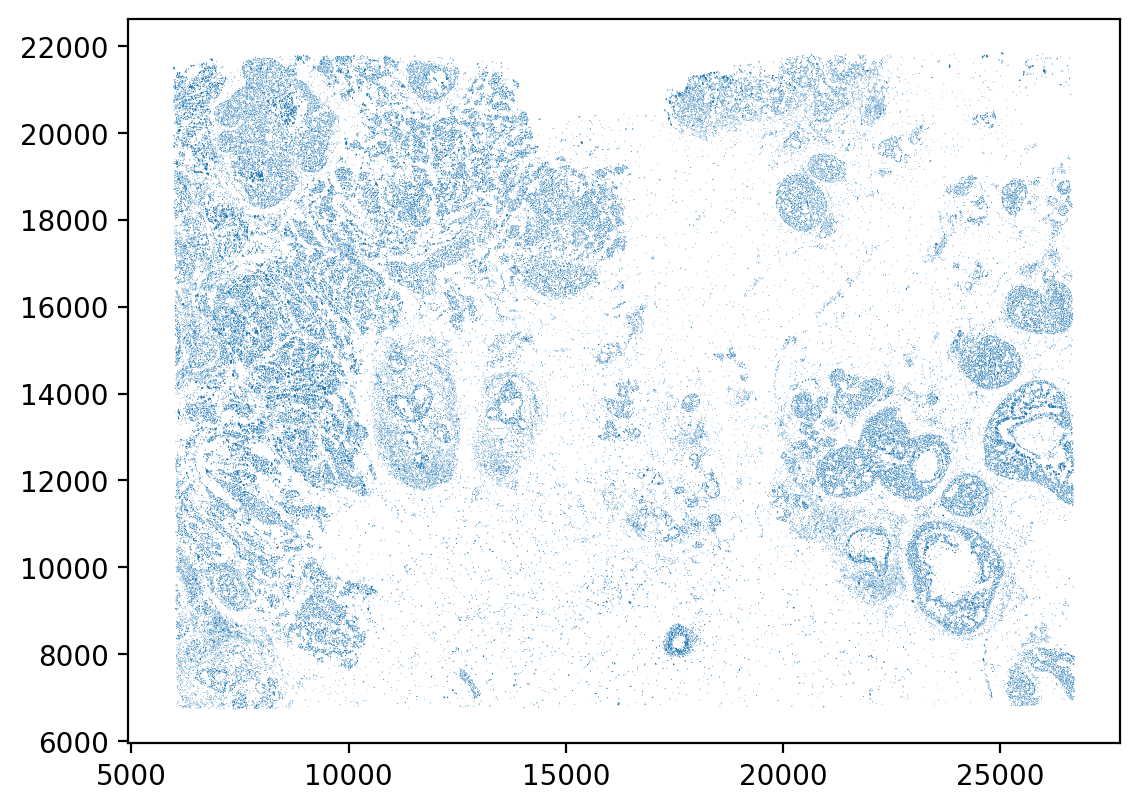

In [44]:
filtered_joined.plot()

In [45]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   
0      ID_100000  POLYGON ((21176.627 13282.000, 21176.226 13282...  \
1      ID_100002  POLYGON ((23761.492 11064.000, 23757.712 11065...   
2      ID_100004  POLYGON ((23474.280 12904.000, 23474.310 12905...   
3      ID_100005  POLYGON ((21813.596 11330.000, 21814.073 11331...   
4      ID_100007  POLYGON ((23127.516 12532.000, 23127.402 12533...   
...          ...                                                ...   
88431   ID_99987  POLYGON ((22340.075 13966.000, 22339.938 13966...   
88432   ID_99989  POLYGON ((21563.787 10904.000, 21563.855 10905...   
88433   ID_99991  POLYGON ((23375.426 12936.000, 23375.143 12937...   
88434   ID_99995  POLYGON ((23854.037 11416.000, 23853.864 11417...   
88435   ID_99999  POLYGON ((21481.133 11146.000, 21480.527 11146...   

               cell_id  
0             128986.0  
1             144585.0  
2             140484.0  
3             131974.0  
4      11427.0,11428.0  
...                ...  
88431         142942.0  
88432         131200.0  
88433         140498.0  
88434         143461.0  
88435         131635.0  

[88436 rows x 3 columns]

In [46]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 4489


In [47]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry   cell_id
0      ID_100000  POLYGON ((21176.627 13282.000, 21176.226 13282...  128986.0
1      ID_100002  POLYGON ((23761.492 11064.000, 23757.712 11065...  144585.0
2      ID_100004  POLYGON ((23474.280 12904.000, 23474.310 12905...  140484.0
3      ID_100005  POLYGON ((21813.596 11330.000, 21814.073 11331...  131974.0
5      ID_100008  POLYGON ((22299.687 10864.000, 22299.217 10865...  145665.0
...          ...                                                ...       ...
88431   ID_99987  POLYGON ((22340.075 13966.000, 22339.938 13966...  142942.0
88432   ID_99989  POLYGON ((21563.787 10904.000, 21563.855 10905...  131200.0
88433   ID_99991  POLYGON ((23375.426 12936.000, 23375.143 12937...  140498.0
88434   ID_99995  POLYGON ((23854.037 11416.000, 23853.864 11417...  143461.0
88435   ID_99999  POLYGON ((21481.133 11146.000, 21480.527 11146...  131635.0

[83947 rows x 3 columns]

In [48]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

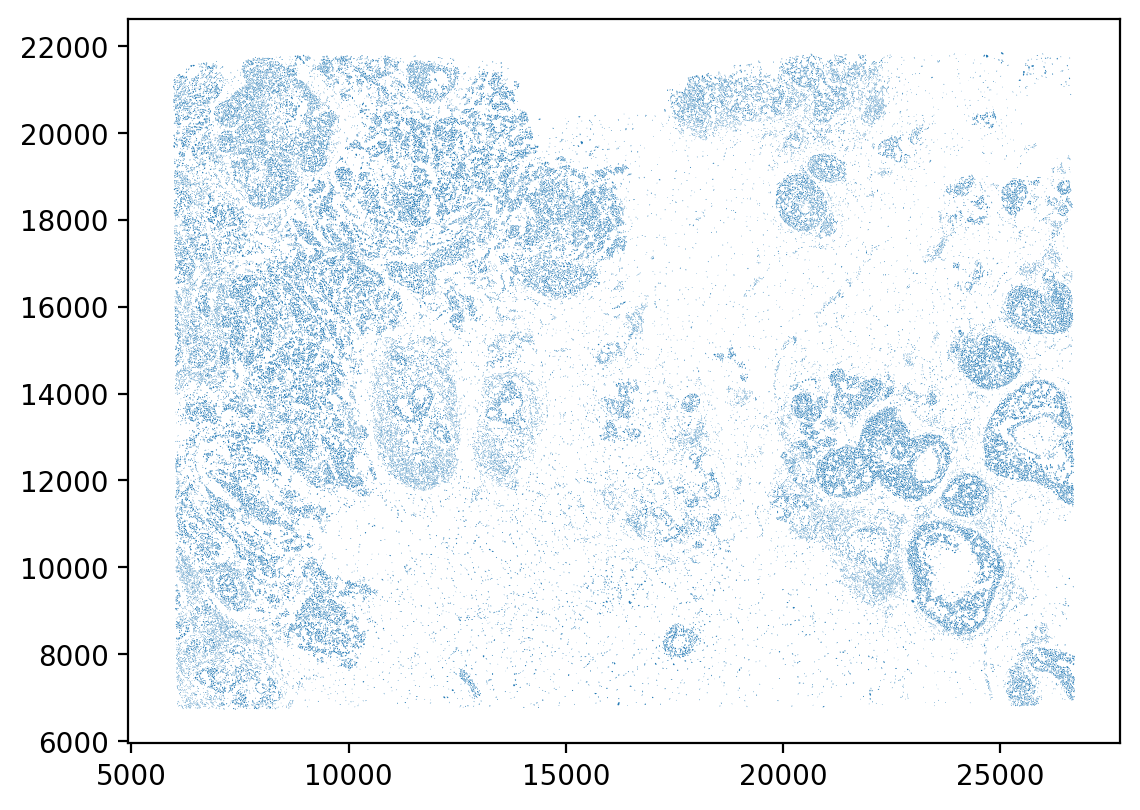

In [49]:
filtered_gdf.plot()

In [50]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/filtered_gdf_stardist.geojson", driver='GeoJSON')

In [51]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 147344 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [53]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 83947 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [54]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_stardist_adata.h5ad")
# IMPORTANT you will need this as ADATA